In [1]:
import numpy as np
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import adadelta
from keras.regularizers import l1
import pydot

C:\Users\goro\AppData\Local\conda\conda\envs\smartcity\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [306]:
def shallow_autoencoder(input_size,embed_size):
    
    x_in = Input(shape=(input_size,))
    X_EN=Dense(embed_size,activation='relu')(x_in)
    X_De=Dense(input_size,activation='sigmoid')(X_EN)
    shallow_autoencoder=Model(inputs=x_in,outputs=X_De)
    
    # encoder model
    
    encoder= Model(inputs=x_in,outputs=X_EN)
    # decoder model
    x_en= Input(shape=(embed_size,))
    decode_layer=shallow_autoencoder.layers[-1]
    decoder= Model(inputs=x_en,outputs=decode_layer(x_en))
    
    
    return shallow_autoencoder,encoder,decoder
    

    
    
    
    
    
def deep_autoencoder(input_size,embed_size):
    
    x_in = Input(shape=(input_size,))
    # encoder 3 dense layers
    X=Dense(512,activation='relu')(x_in)
    X=Dense(256,activation='relu')(X)
    X=Dense(128,activation='relu')(X)
    
    
    X_EN=Dense(embed_size,activation='relu')(X)
    
    # decoder 3 dense layers  symmetric

    X=Dense(128,activation='relu')(X_EN)
    X=Dense(256,activation='relu')(X)
    X=Dense(512,activation='relu')(X)
    
    X_De=Dense(input_size,activation='sigmoid')(X)
    
    deep_autoencoder=Model(inputs=x_in,outputs=X_De)
    
    # encoder model
    
    encoder= Model(inputs=x_in,outputs=X_EN)
    decoder=None
    
    
    
    
    return deep_autoencoder,encoder,decoder
    
    
    
    
def sparse_deep_autoencoder(input_size,embed_size):
    
    x_in = Input(shape=(input_size,))
    # encoder 3 dense layers
    X=Dense(512,activation='relu')(x_in)
    X=Dense(256,activation='relu')(X)
    X=Dense(128,activation='relu')(X)
    
    
    X_EN=Dense(embed_size,activation='relu',activity_regularizer=l1(10e-6))(X)  # sparse constraint on encoder 
    
    # decoder 3 dense layers  symmetric

    X=Dense(128,activation='relu')(X_EN)
    X=Dense(256,activation='relu')(X)
    X=Dense(512,activation='relu')(X)
    
    X_De=Dense(input_size,activation='sigmoid')(X)
    
    sparse_deep_autoencoder=Model(inputs=x_in,outputs=X_De)
    
    # encoder model
    
    sparse_encoder= Model(inputs=x_in,outputs=X_EN)
    decoder=None
    
    
    return sparse_deep_autoencoder,sparse_encoder,decoder
    
def denoise_deep_autoencoder(input_size):
    return None 
    
def contractive_autoencoder(input_size):
    return None 
    
def variation_autoencoder(input_size):
    return None 
    
    

shallow_autoencoder, encoder, decoder = shallow_autoencoder(input_size=784,embed_size=64)
deep_autoencoder, encoder, decoder = deep_autoencoder(input_size=784,embed_size=64)
sparse_deep_autoencoder, encoder, decoder = sparse_deep_autoencoder(input_size=784,embed_size=64)
#denoise_deep_autoencoder, encoder, decoder = deep_autoencoder(input_size=784,embed_size=64)
    
    


TypeError: __call__() missing 1 required positional argument: 'inputs'

In [41]:
shallow_autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [42]:
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
__________

In [43]:
sparse_deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               33024     
__________

In [44]:
def model_compile(model,opt,los):
    model.compile(optimizer=opt,loss=los)
    return model
    
    
def model_train(model,x_train,y_train,x_test,y_test,batch_size,epochs,shuffle=True): # generic for image denoising 
    history=model.fit(x_train, x_train,epochs=epochs,batch_size=batch_size,shuffle=True,validation_data=(x_test, x_test))
    return model,history

shallow_autoencoder=model_compile(shallow_autoencoder, opt='adadelta',los='binary_crossentropy')



    
    
    

In [273]:
def data_loading():
    from keras.datasets import mnist
    (x_train,_), (x_test,_) = mnist.load_data()
    return x_train,x_test

x_train , x_test = data_loading()



def image_noise(x_train,x_test):
    
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
    noise_factor = 0.5
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy,x_test_noisy


x_train_noisy,x_test_noisy=image_noise(x_train,x_test)


    
    
    
    

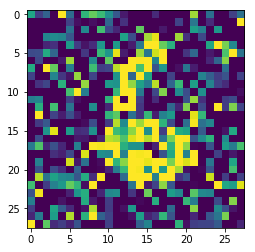

In [289]:
x_train_noisy.shape
image=x_train_noisy[np.random.randint(0,100)]
image.shape
plt.imshow(image.reshape(28,28))
#plt.imshow(x_train_noisy[0,:,:,:])

In [290]:
x_test.shape

(10000, 28, 28)

In [292]:
def data_preprocess(x):
    return (x.astype('float32')/255).reshape(x.shape[0],np.prod(x.shape[1:]))

x_train=data_preprocess(x_train)
#model_train(model,x_train,x_test,batch_size,epochs,shuffle=True)


In [293]:
x_train.shape

(60000, 784)

In [294]:
x_test=data_preprocess(x_test)

In [295]:
x_test.shape

(10000, 784)

In [45]:
shallow_autoencoder, history = model_train(model=shallow_autoencoder,x_train=x_train,x_test=x_test,batch_size=256,epochs=40,shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 2s 30us/step - loss: 0.3454 - val_loss: 0.2674
Epoch 2/40
60000/60000 [==============================] - 2s 25us/step - loss: 0.2570 - val_loss: 0.2430
Epoch 3/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.2319 - val_loss: 0.2188
Epoch 4/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.2112 - val_loss: 0.2015
Epoch 5/40
60000/60000 [==============================] - 1s 23us/step - loss: 0.1965 - val_loss: 0.1891
Epoch 6/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.1858 - val_loss: 0.1797
Epoch 7/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.1773 - val_loss: 0.1721
Epoch 8/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.1702 - val_loss: 0.1656
Epoch 9/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.1641 - val_loss: 0.1600
Epoch

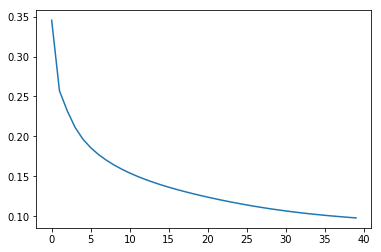

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(history.history['loss'])
plt.show()

In [40]:
history.history['loss']

[0.09142509981791179,
 0.0910178614139557,
 0.09062822986841201,
 0.0902526234984398,
 0.08989529472986857,
 0.08955204048156738,
 0.08921960943539937,
 0.08890282223622004,
 0.08859600134293238,
 0.08830226904153823]

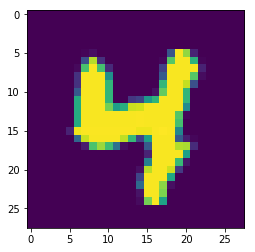

In [47]:
def model_generation(model,image):
    recon_image = model.predict(image)
    return recon_image
    
    
index=np.random.randint(0,100)    
image=x_test[index]
image.shape
image=np.expand_dims(image,axis=0)
image.shape    

recon_image=model_generation(shallow_autoencoder,image)

or_image= image.reshape(image.shape[0],28,28)
recon_image=recon_image.reshape(recon_image.shape[0],28,28)

plt.figure
plt.imshow(or_image[0,:,:])





    
    

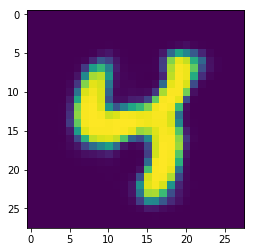

In [48]:
plt.figure
plt.imshow(recon_image[0,:,:])

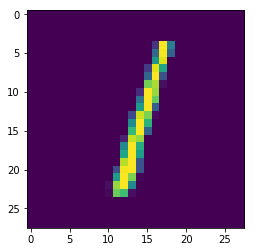

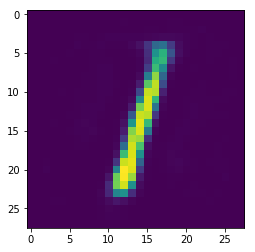

In [49]:
deep_autoencoder=model_compile(deep_autoencoder, opt='adadelta',los='binary_crossentropy')

In [51]:
deep_autoencoder, history = model_train(model=deep_autoencoder,x_train=x_train,x_test=x_test,batch_size=256,epochs=130,shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/130
60000/60000 [==============================] - 3s 51us/step - loss: 0.1144 - val_loss: 0.1133
Epoch 2/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1136 - val_loss: 0.1123
Epoch 3/130
60000/60000 [==============================] - 3s 49us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 4/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1118 - val_loss: 0.1112
Epoch 5/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1110 - val_loss: 0.1095
Epoch 6/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1102 - val_loss: 0.1093
Epoch 7/130
60000/60000 [==============================] - 3s 49us/step - loss: 0.1092 - val_loss: 0.1089
Epoch 8/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1086 - val_loss: 0.1073
Epoch 9/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.1079 - val_loss: 0.1

60000/60000 [==============================] - 3s 50us/step - loss: 0.0892 - val_loss: 0.0908
Epoch 78/130
60000/60000 [==============================] - 3s 51us/step - loss: 0.0891 - val_loss: 0.0889
Epoch 79/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.0889 - val_loss: 0.0891
Epoch 80/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.0888 - val_loss: 0.0885
Epoch 81/130
60000/60000 [==============================] - 3s 52us/step - loss: 0.0888 - val_loss: 0.0904
Epoch 82/130
60000/60000 [==============================] - 3s 51us/step - loss: 0.0886 - val_loss: 0.0892
Epoch 83/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.0885 - val_loss: 0.0889
Epoch 84/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.0884 - val_loss: 0.0881
Epoch 85/130
60000/60000 [==============================] - 3s 50us/step - loss: 0.0883 - val_loss: 0.0884
Epoch 86/130
60000/60000 [========================

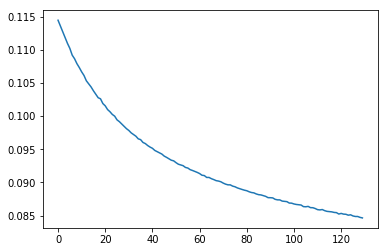

In [52]:
plt.plot(history.history['loss'])
plt.show()

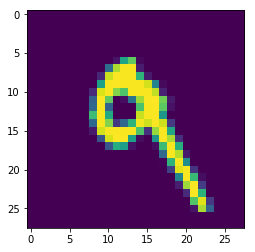

In [53]:
index=np.random.randint(0,100)    
image=x_test[index]
image.shape
image=np.expand_dims(image,axis=0)
image.shape    

recon_image=model_generation(deep_autoencoder,image)

or_image= image.reshape(image.shape[0],28,28)
recon_image=recon_image.reshape(recon_image.shape[0],28,28)

plt.figure
plt.imshow(or_image[0,:,:])

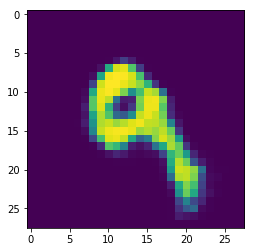

In [54]:
plt.imshow(recon_image[0,:,:])

In [55]:
sparse_deep_autoencoder=model_compile(sparse_deep_autoencoder, opt='adadelta',los='binary_crossentropy')

In [57]:
sparse_deep_autoencoder, history = model_train(model=sparse_deep_autoencoder,x_train=x_train,x_test=x_test,batch_size=256,epochs=2,shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 3s 52us/step - loss: 0.1477 - val_loss: 0.1517
Epoch 2/2
60000/60000 [==============================] - 3s 50us/step - loss: 0.1476 - val_loss: 0.1526


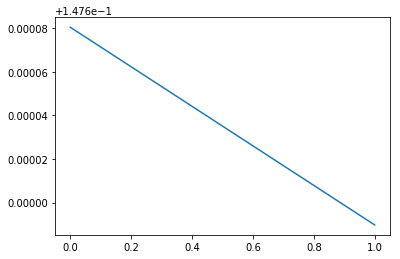

In [58]:
plt.plot(history.history['loss'])

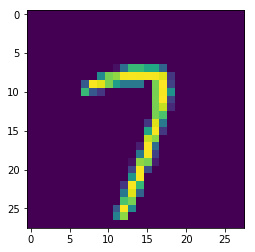

In [255]:
index=np.random.randint(0,1000)    
image=x_test[index]
image.shape
image=np.expand_dims(image,axis=0)
image.shape    

recon_image_shallow=model_generation(shallow_autoencoder,image)
recon_image_deep=model_generation(deep_autoencoder,image)
recon_image_sparse_deep=model_generation(sparse_deep_autoencoder,image)


or_image= image.reshape(image.shape[0],28,28)

plt.figure
plt.imshow(or_image[0,:,:]*255)

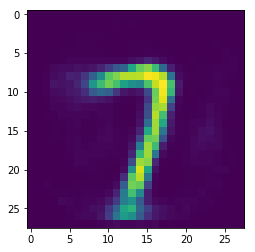

In [256]:
plt.figure
recon_image_shallow=recon_image_shallow.reshape(recon_image_shallow.shape[0],28,28)
plt.imshow(recon_image_shallow[0,:,:]*255)

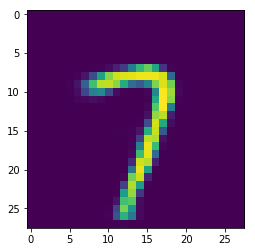

In [257]:
plt.figure
recon_image_deep=recon_image_deep.reshape(recon_image_deep.shape[0],28,28)
plt.imshow(recon_image_deep[0,:,:]*255)

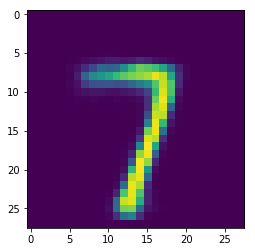

In [258]:
plt.figure
recon_image_sparse_deep=recon_image_sparse_deep.reshape(recon_image_sparse_deep.shape[0],28,28)
plt.imshow(recon_image_sparse_deep[0,:,:]*255)

In [265]:
def make_noise(x_train,x_test):
        noise_factor = 0.5
        x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
        x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        x_test_noisy = np.clip(x_test_noisy, 0., 1.)
        return x_train_noisy,x_test_noisy

x_train, x_test = make_noise(x_train,x_test)

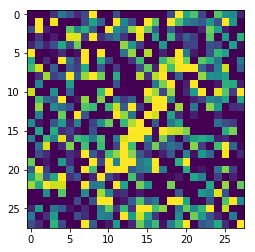

In [271]:
plt.imshow(x_train.reshape(x_train.shape[0],28,28)[3])

In [296]:
x_train_noisy=data_preprocess(x_train_noisy)

In [297]:
x_train_noisy.shape

(60000, 784)

In [298]:
x_test_noisy=data_preprocess(x_test_noisy)

In [299]:
x_test_noisy.shape

(10000, 784)

In [307]:
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_59 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_61 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_62 (Dense)             (None, 256)               33024     
__________

In [ ]:
history=model_train(deep_autoencoder,x_train=x_train_noisy,y_train=x_train,x_test=x_test_noisy,y_test,batch_size,epochs,shuffle=True):